In [ ]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Input, Concatenate, UpSampling2D,BatchNormalization, Add
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import cv2
import nibabel
import random as r
import pandas as pd
import numpy as np
import random
import glob
from skimage.io import imread,imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from PIL import Image
from keras import backend, optimizers
import skimage.io as io

In [ ]:
%pip install segmentation-models-3D

In [ ]:
import segmentation_models_3D as sm

In [ ]:
orig_path = r"./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"
files_flair = glob.glob(orig_path+"**/*flair.nii")
files_t1ce = glob.glob(orig_path+"**/*t1ce.nii")
files_t2 = glob.glob(orig_path+"**/*t2.nii")
files_seg = glob.glob(orig_path+"**/*seg.nii")
r.seed(42)
r.shuffle(files_flair)
r.seed(42)
r.shuffle(files_t1ce)
r.seed(42)
r.shuffle(files_t2)
r.seed(42)
r.shuffle(files_seg)

In [ ]:
print(len(files_flair), len(files_t1ce), len(files_t2), len(files_seg))

369 369 369 369


In [ ]:
img_num = random.randint(0,len(files_flair)-1)
random_img = io.imread(files_flair[img_num])

print(f"shape: {random_img.shape}")
print(f"dtype: {random_img.dtype}")

shape: (155, 240, 240)
dtype: float32


In [ ]:
# def remove_keymap_conflicts(new_keys_set):
#     for prop in plt.rcParams:
#         if prop.startswith('keymap.'):
#             keys = plt.rcParams[prop]
#             remove_list = set(keys) & new_keys_set
#             for key in remove_list:
#                 keys.remove(key)
# def multi_slice_viewer(volume):
#     remove_keymap_conflicts({'j', 'k'})
#     fig, ax = plt.subplots()
#     ax.volume = volume
#     ax.index = volume.shape[0] // 2
#     ax.imshow(volume[ax.index])
#     fig.canvas.mpl_connect('key_press_event', process_key)

# def process_key(event):
#     fig = event.canvas.figure
#     ax = fig.axes[0]
#     if event.key == 'j':
#         previous_slice(ax)
#     elif event.key == 'k':
#         next_slice(ax)
#     fig.canvas.draw()

# def previous_slice(ax):
#     volume = ax.volume
#     ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
#     ax.images[0].set_array(volume[ax.index])

# def next_slice(ax):
#     volume = ax.volume
#     ax.index = (ax.index + 1) % volume.shape[0]
#     ax.images[0].set_array(volume[ax.index])

Image No: 79 slice no: 69


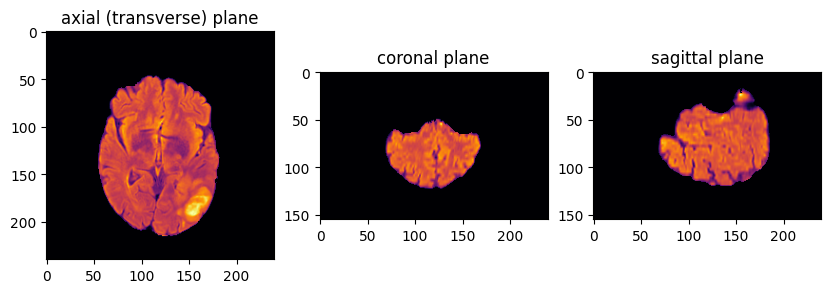

In [ ]:
# just showing a random image
img_num = random.randint(0,len(files_flair)-1)
n_slice=random.randint(0, 154)

fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(random_img[n_slice,:,:], cmap='inferno')
plt.title("axial (transverse) plane")

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(random_img[:,n_slice,:], cmap='inferno')
plt.title("coronal plane")

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(random_img[:,:,n_slice], cmap='inferno')
plt.title("sagittal plane")
print("Image No:", img_num, "slice no:", n_slice)

Text(0.5, 1.0, 'seg')

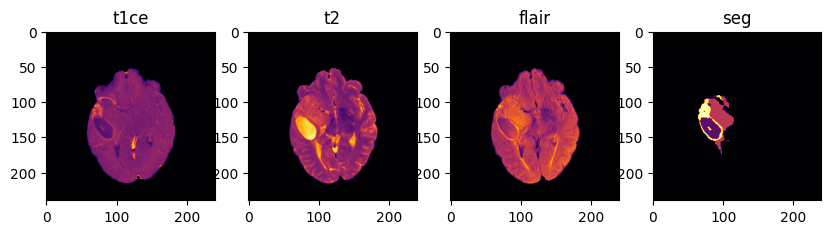

In [ ]:
img_num = random.randint(0,len(files_flair)-1)
random_img_t1ce = io.imread(files_t1ce[img_num])
random_img_t2 = io.imread(files_t2[img_num])
random_img_flair = io.imread(files_flair[img_num])
random_img_seg = io.imread(files_seg[img_num])

n_slice=random.randint(0, 154)

fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(random_img_t1ce[n_slice,:,:], cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(1, 4, 2)
ax1.imshow(random_img_t2[n_slice,:,:], cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(1, 4, 3)
ax1.imshow(random_img_flair[n_slice,:,:], cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(1, 4, 4)
ax1.imshow(random_img_seg[n_slice,:,:], cmap='inferno')
plt.title("seg")

In [ ]:
# def to_array(path, end):
#     files = glob.glob(path+end, recursive=True)
#     img_list = []
#     r.seed(42)
#     r.shuffle(files)
#     for file in files:
#         img = io.imread(file, plugin="simpleitk")
#         img = (img-img.mean())/img.std()
#         img.astype("float32")
#         for slice in range(60, 70):
#             img_s = img[slice,:,:]
#             img_s = cv2.resize(img_s, (128,128))
#             img_s = np.expand_dims(img_s, axis=2)
#             img_list.append(img_s)
#     return np.array(img_list,np.float32)
def to_array(path):
    t1ce_files = glob.glob(path+"**/*t1ce.nii", recursive=True)
    t2_files = glob.glob(path+"**/*t2.nii", recursive=True)
    flair_files = glob.glob(path+"**/*flair.nii", recursive=True)
    # t1ce_files=sorted(t1ce_files)
    # t2_files=sorted(t2_files)
    # flair_files=sorted(flair_files)

    X = []
    r.seed(42)
    r.shuffle(t1ce_files)
    r.seed(42)
    r.shuffle(t2_files)
    r.seed(42)
    r.shuffle(flair_files)
    for t1ce,t2,flair in zip(t1ce_files, t2_files,flair_files):
        t1ce = io.imread(t1ce, plugin="simpleitk")
        t2 = io.imread(t2, plugin="simpleitk")
        flair = io.imread(flair, plugin="simpleitk")
        t1ce = (t1ce-t1ce.mean())/t1ce.std()
        t2 = (t2-t2.mean())/t2.std()
        flair = (flair-flair.mean())/flair.std()

        t1ce.astype("float32")
        t2.astype("float32")
        flair.astype("float32")

        for slice in range(60, 70):
            img_t1ce = t1ce[slice,:,:]
            img_t2 = t2[slice,:,:]
            img_flair = flair[slice,:,:]

            img_t1ce = cv2.resize(img_t1ce, (128,128))
            img_t2 = cv2.resize(img_t2, (128,128))
            img_flair = cv2.resize(img_flair, (128,128))
            stacked_array = np.dstack((img_t1ce, img_t2, img_flair))

            X.append(stacked_array)
    return np.array(X,np.float32)

In [ ]:
def seg_to_array(path, end, label):
    files = glob.glob(path+end, recursive=True)
    # files = sorted(files)
    img_list = []
    r.seed(42)
    r.shuffle(files)
    for file in files:
        img = io.imread(file, plugin="simpleitk")
        if label == 1:
            img[img != 0] = 1
        if label == 2:
            img[img != 1] = 0
        if label == 3:
            img[img == 2] = 0
            img[img != 0] = 1
        if label == 4:
            img[img != 4] = 0
            img[img == 4] = 1
        img.astype("float32")
        for slice in range(60, 70):
            img_s = img[slice,:,:]
            img_s = cv2.resize(img_s, (128,128))
            img_s = np.expand_dims(img_s, axis=2)
            img_list.append(img_s)
    return np.array(img_list,np.float32)

In [ ]:
# not to be run everytime
#run only if you need to preprocess the data this time

# flair = to_array(path=orig_path, end="**/*flair.nii")
X = to_array(path=orig_path)
# t2 = to_array(path=orig_path, end="**/*t2.nii")
Y = seg_to_array(path=orig_path, end="**/*seg.nii", label=1)

In [ ]:
# flair = to_array(path=orig_path, end="**/*flair.nii")
# t2 = to_array(path=orig_path, end="**/*t2.nii")

In [ ]:
# seg.shape, t1ce.shape
#t2.shape, flair.shape
X.shape, Y.shape

((3690, 128, 128, 3), (3690, 128, 128, 1))

Text(0.5, 1.0, 'seg 2717')

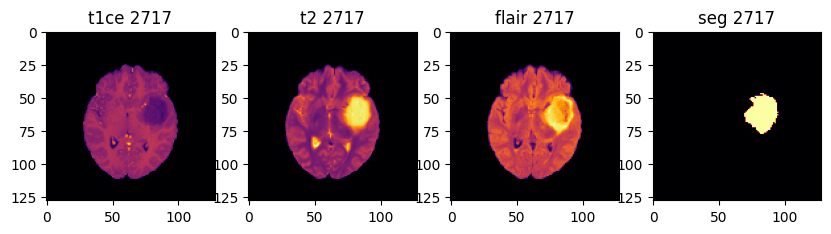

In [ ]:
# not to be run everytime
# run only if X and Y has been loaded
img_num = random.randint(0,len(X)-1)
random_img_t1ce = X[img_num,:,:,0]
random_img_t2 = X[img_num,:,:,1]
random_img_flair = X[img_num,:,:,2]
random_img_seg = Y[img_num,:,:,0]

# n_slice=random.randint(0, 154)

fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title(f"t1ce {img_num}")

ax1 = fig.add_subplot(1, 4, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title(f"t2 {img_num}")

ax1 = fig.add_subplot(1, 4, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title(f"flair {img_num}")

ax1 = fig.add_subplot(1, 4, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title(f"seg {img_num}")

In [ ]:
# not to be run everytime
# run only if X and Y has been loaded

# X_train_t2_flair = np.concatenate((flair, t2))
# X_train_t1ce_t2_flair = np.concatenate((flair, t2, t1ce))

# X_train_t2_flair.shape, X_train_t1ce_t2_flair.shape
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [ ]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((2767, 128, 128, 3),
 (923, 128, 128, 3),
 (2767, 128, 128, 1),
 (923, 128, 128, 1))

Text(0.5, 1.0, 'seg')

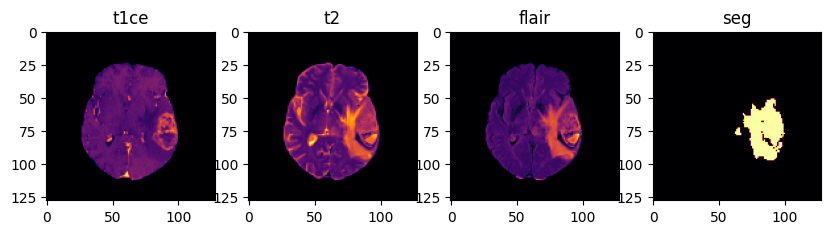

In [ ]:
# not to be run everytime
# run only if X_train and Y_train has been loaded

img_num = random.randint(0,len(X_train)-1)
random_img_t1ce = X_train[img_num,:,:,0]
random_img_t2 = X_train[img_num,:,:,1]
random_img_flair = X_train[img_num,:,:,2]
random_img_seg = Y_train[img_num,:,:,0]

# n_slice=random.randint(0, 154)

fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(1, 4, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(1, 4, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(1, 4, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

Text(0.5, 1.0, 'seg')

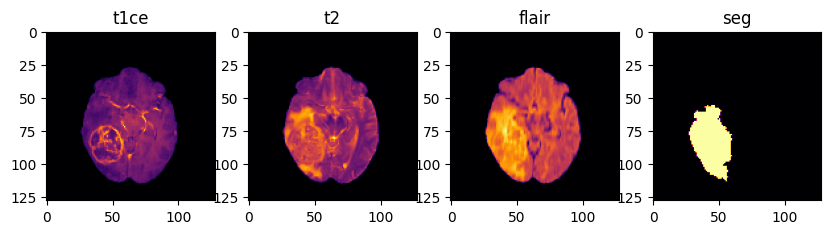

In [ ]:
# not to be run everytime
# run only if X_test and Y_test has been loaded

img_num = random.randint(0,len(X_test)-1)
random_img_t1ce = X_test[img_num,:,:,0]
random_img_t2 = X_test[img_num,:,:,1]
random_img_flair = X_test[img_num,:,:,2]
random_img_seg = Y_test[img_num,:,:,0]

# n_slice=random.randint(0, 154)

fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(1, 4, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(1, 4, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(1, 4, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

In [ ]:
import pickle

In [ ]:
# not to be run everytime
# run only if you want to save

with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)

In [ ]:
# not to be run everytime
# run only if you want to save

with open('Y_train.pkl', 'wb') as f:
    pickle.dump(Y_train, f)

In [ ]:
# not to be run everytime
# run only if you want to save

with open('X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)

In [ ]:
# not to be run everytime
# run only if you want to save

with open('Y_test.pkl', 'wb') as f:
    pickle.dump(Y_test, f)

In [ ]:
# loading the saved preprocessed data from local device

with open(X_train.pkl, 'rb') as f:
    X_train_load = pickle.load(f)
with open('Y_train.pkl', 'rb') as f:
    Y_train_load = pickle.load(f)
with open('X_test.pkl', 'rb') as f:
    X_test_load = pickle.load(f)
with open('Y_test.pkl', 'rb') as f:
    Y_test_load = pickle.load(f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X_train = '/content/drive/MyDrive/final yr project/X_train.pkl'
Y_train="/content/drive/MyDrive/final yr project/Y_train.pkl"
X_test="/content/drive/MyDrive/final yr project/X_test.pkl"
Y_test="/content/drive/MyDrive/final yr project/Y_test.pkl"

In [ ]:
with open(X_train, 'rb') as f:
    X_train_load = pickle.load(f)
with open(Y_train, 'rb') as f:
    Y_train_load = pickle.load(f)
with open(X_test, 'rb') as f:
     X_test_load = pickle.load(f)
with open(Y_test, 'rb') as f:
     Y_test_load = pickle.load(f)


In [ ]:
X_train_load.shape, X_test_load.shape, Y_train_load.shape, Y_test_load.shape

((2767, 128, 128, 3),
 (923, 128, 128, 3),
 (2767, 128, 128, 1),
 (923, 128, 128, 1))

Text(0.5, 1.0, 'seg')

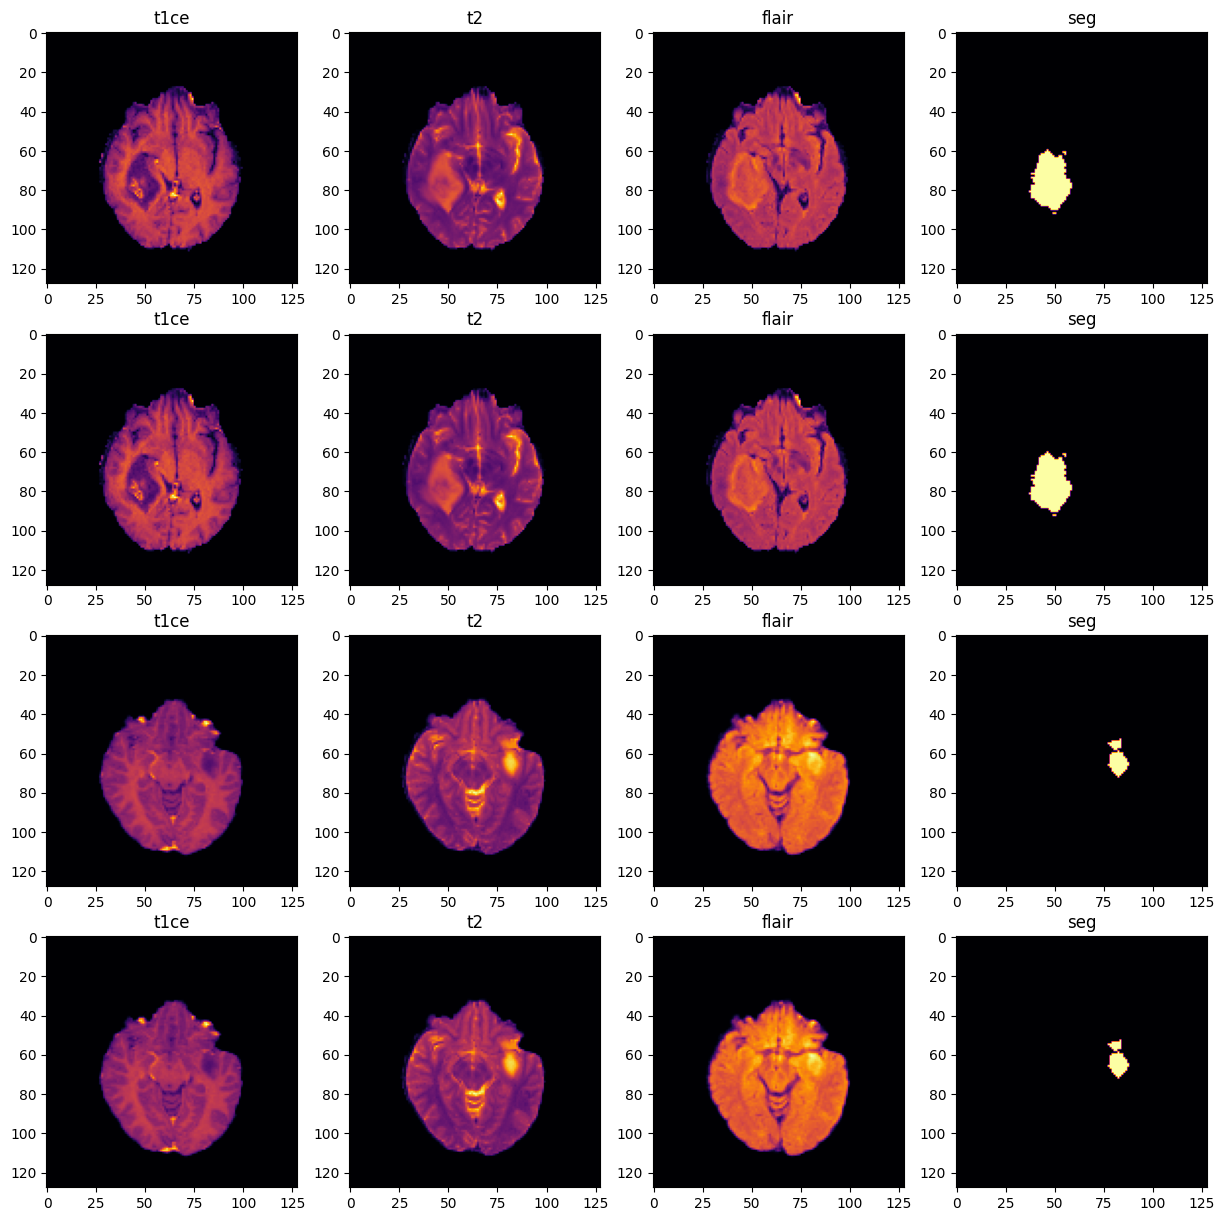

In [ ]:
# not to be run everytime
# run only if X_train,X_test,Y_train,Y_test has been loaded

img_num = random.randint(0,len(X_train)-1)

# train
random_img_t1ce = X_train[img_num,:,:,0]
random_img_t2 = X_train[img_num,:,:,1]
random_img_flair = X_train[img_num,:,:,2]
random_img_seg = Y_train[img_num,:,:,0]

# n_slice=random.randint(0, 154)

fig = plt.figure(figsize =(15, 15))

ax1 = fig.add_subplot(4, 4, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

# train_load
random_img_t1ce = X_train_load[img_num,:,:,0]
random_img_t2 = X_train_load[img_num,:,:,1]
random_img_flair = X_train_load[img_num,:,:,2]
random_img_seg = Y_train_load[img_num,:,:,0]

# n_slice=random.randint(0, 154)

# fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(4, 4, 5)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 6)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 7)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 8)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

# test

img_num = random.randint(0,len(X_test)-1)

random_img_t1ce = X_test[img_num,:,:,0]
random_img_t2 = X_test[img_num,:,:,1]
random_img_flair = X_test[img_num,:,:,2]
random_img_seg = Y_test[img_num,:,:,0]

# n_slice=random.randint(0, 154)

# fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(4, 4, 9)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 10)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 11)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 12)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

# test_load

# img_num = random.randint(0,len(X_test)-1)

random_img_t1ce = X_test_load[img_num,:,:,0]
random_img_t2 = X_test_load[img_num,:,:,1]
random_img_flair = X_test_load[img_num,:,:,2]
random_img_seg = Y_test_load[img_num,:,:,0]

# n_slice=random.randint(0, 154)

# fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(4, 4, 13)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 14)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 15)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 16)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

In [ ]:
X_train = X_train_load
X_test = X_test_load
Y_train = Y_train_load
Y_test = Y_test_load

Text(0.5, 1.0, 'seg')

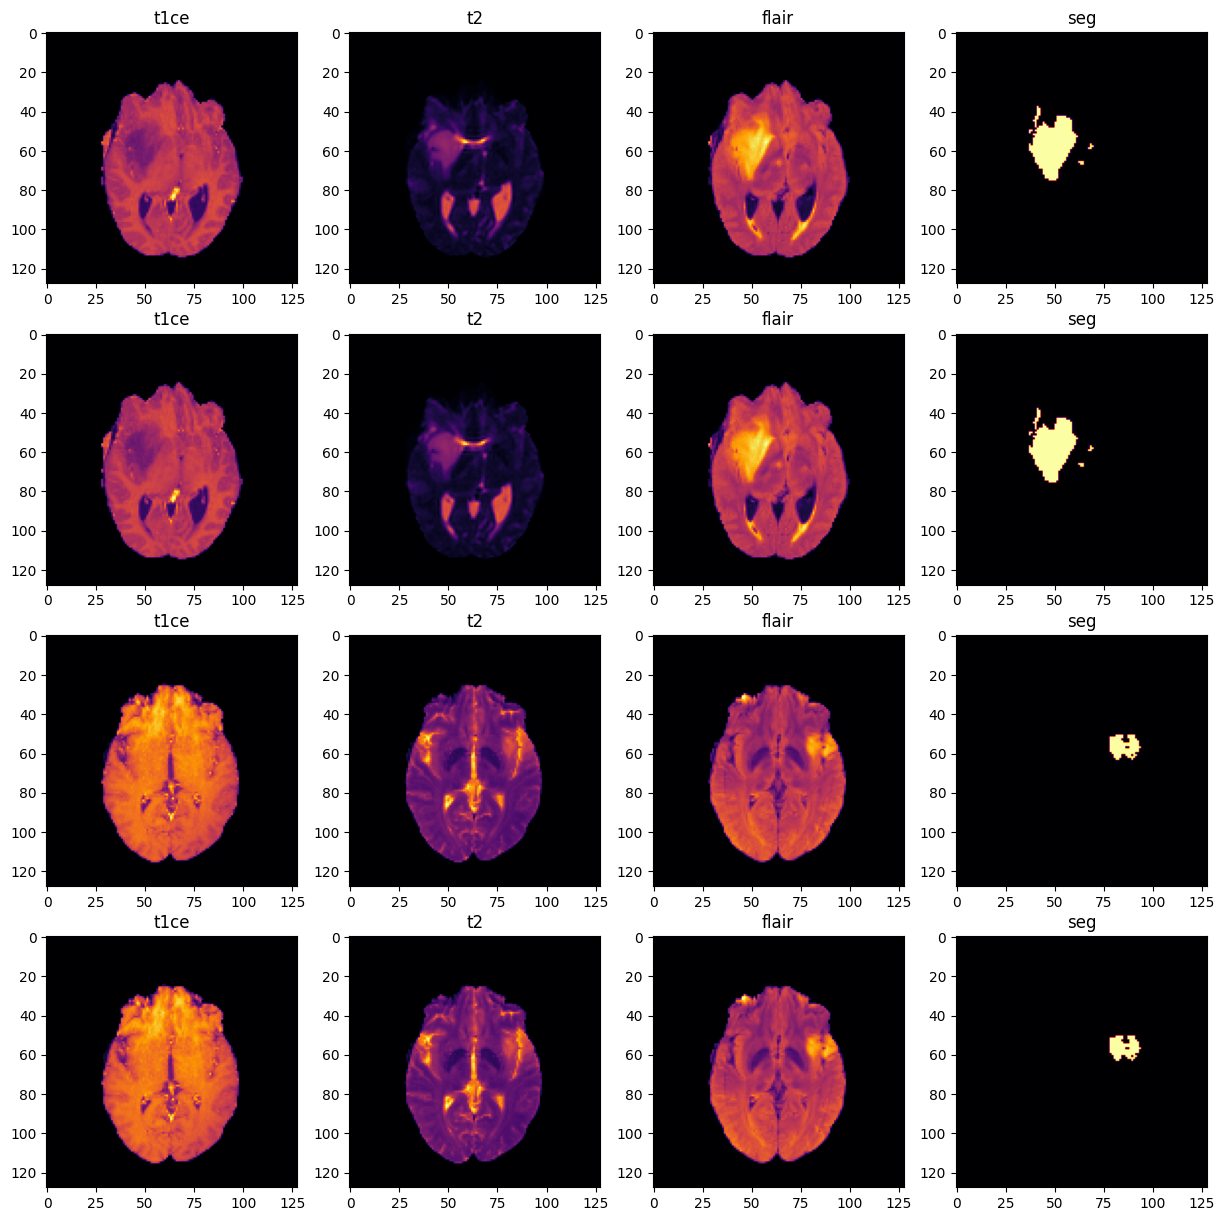

In [ ]:


img_num = random.randint(0,len(X_train)-1)

# train
random_img_t1ce = X_train[img_num,:,:,0]
random_img_t2 = X_train[img_num,:,:,1]
random_img_flair = X_train[img_num,:,:,2]
random_img_seg = Y_train[img_num,:,:,0]

# n_slice=random.randint(0, 154)

fig = plt.figure(figsize =(15, 15))

ax1 = fig.add_subplot(4, 4, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

# train_load
random_img_t1ce = X_train_load[img_num,:,:,0]
random_img_t2 = X_train_load[img_num,:,:,1]
random_img_flair = X_train_load[img_num,:,:,2]
random_img_seg = Y_train_load[img_num,:,:,0]

# n_slice=random.randint(0, 154)

# fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(4, 4, 5)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 6)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 7)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 8)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

# test

img_num = random.randint(0,len(X_test)-1)

random_img_t1ce = X_test[img_num,:,:,0]
random_img_t2 = X_test[img_num,:,:,1]
random_img_flair = X_test[img_num,:,:,2]
random_img_seg = Y_test[img_num,:,:,0]

# n_slice=random.randint(0, 154)

# fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(4, 4, 9)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 10)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 11)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 12)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

# test_load

# img_num = random.randint(0,len(X_test)-1)

random_img_t1ce = X_test_load[img_num,:,:,0]
random_img_t2 = X_test_load[img_num,:,:,1]
random_img_flair = X_test_load[img_num,:,:,2]
random_img_seg = Y_test_load[img_num,:,:,0]

# n_slice=random.randint(0, 154)

# fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(4, 4, 13)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 14)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 15)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 16)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

Text(0.5, 1.0, 'seg')

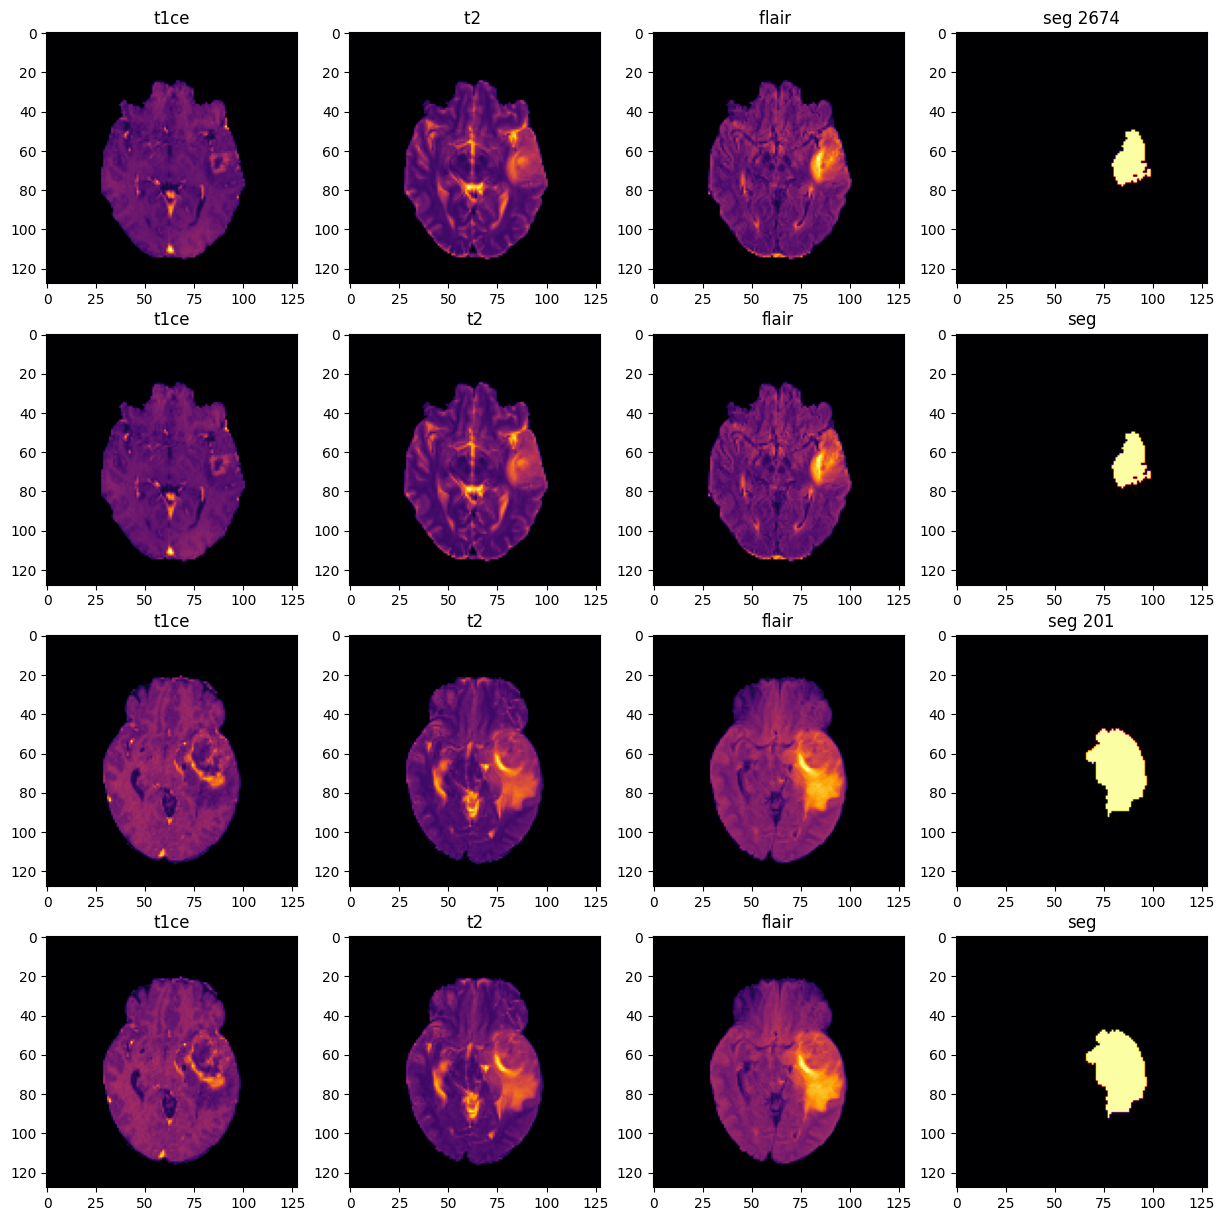

In [ ]:


img_num = random.randint(0,len(X_train)-1)

# train
random_img_t1ce = X_train[img_num,:,:,0]
random_img_t2 = X_train[img_num,:,:,1]
random_img_flair = X_train[img_num,:,:,2]
random_img_seg = Y_train[img_num,:,:,0]

# n_slice=random.randint(0, 154)

fig = plt.figure(figsize =(15, 15))

ax1 = fig.add_subplot(4, 4, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2 ")

ax1 = fig.add_subplot(4, 4, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair ")

ax1 = fig.add_subplot(4, 4, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title(f"seg {img_num}")

# train_load
random_img_t1ce = X_train_load[img_num,:,:,0]
random_img_t2 = X_train_load[img_num,:,:,1]
random_img_flair = X_train_load[img_num,:,:,2]
random_img_seg = Y_train_load[img_num,:,:,0]

# n_slice=random.randint(0, 154)

# fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(4, 4, 5)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 6)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 7)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 8)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

# test

img_no = random.randint(0,len(X_test)-1)

random_img_t1ce = X_test[img_no,:,:,0]
random_img_t2 = X_test[img_no,:,:,1]
random_img_flair = X_test[img_no,:,:,2]
random_img_seg = Y_test[img_no,:,:,0]

# n_slice=random.randint(0, 154)

# fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(4, 4, 9)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 10)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 11)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 12)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title(f"seg {img_no}")

# test_load

# img_num = random.randint(0,len(X_test)-1)

random_img_t1ce = X_test_load[img_no,:,:,0]
random_img_t2 = X_test_load[img_no,:,:,1]
random_img_flair = X_test_load[img_no,:,:,2]
random_img_seg = Y_test_load[img_no,:,:,0]

# n_slice=random.randint(0, 154)

# fig = plt.figure(figsize =(10, 10))

ax1 = fig.add_subplot(4, 4, 13)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(4, 4, 14)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(4, 4, 15)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(4, 4, 16)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

In [ ]:
#train-429,2674,
#test-201

In [ ]:
# def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'):
#     conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(inputs)
#     conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(conv)
#     return conv

# def residual_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'):
#     res1 = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(inputs)
#     res2 = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(res1)
#     res3 = Conv2D(filters, (1,1), activation=activation, padding=padding, kernel_initializer=kernel_initializer)(res1)
#     res = Add()([res2, res3])
#     return res

# def attention_block(inputs, skip, filters, kernel_size=(1, 1), activation='relu', padding='same', kernel_initializer='he_normal'):
#     g = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(inputs)
#     x = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(skip)
#     x = Add()([g, x])
#     x = Activation('relu')(x)
#     x = Conv2D(1, (1, 1), activation='sigmoid', padding='same', kernel_initializer='he_normal')(x)
#     x = tf.multiply(x, inputs)
#     return x

# def custom_vgg19(input_shape=(256, 256, 1)):
#     inputs = Input(input_shape)

#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
#     x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     block_1_out = MaxPooling2D((2, 2), strides=(2, 2))(x)


#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(block_1_out)
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     block_2_out = MaxPooling2D((2, 2), strides=(2, 2))(x)


#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(block_2_out)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     block_3_out = MaxPooling2D((2, 2), strides=(2, 2))(x)


#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(block_3_out)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     block_4_out = MaxPooling2D((2, 2), strides=(2, 2))(x)


#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(block_4_out)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#     block_5_out = MaxPooling2D((2, 2), strides=(2, 2))(x)

#     return [inputs, block_1_out, block_2_out, block_3_out, block_4_out, block_5_out]

# def vgg19_unet(input_size=(256, 256, 1)):
#     inputs, block_1_out, block_2_out, block_3_out, block_4_out, block_5_out = custom_vgg19(input_shape=input_size)

#     # Build U-Net model
#     conv1 = residual_block(inputs, 64)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = residual_block(pool1, 128)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#     conv3 = residual_block(pool2, 256)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#     conv4 = residual_block(pool3, 512)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     conv5 = residual_block(pool4, 1024)
#     batch5 = BatchNormalization()(conv5)

#     up6 = UpSampling2D(size=(2, 2))(batch5)
#     up6 = attention_block(up6, conv4, 512)
#     conv6 = residual_block(up6, 512)
#     batch6 = BatchNormalization()(conv6)

#     up7 = UpSampling2D(size=(2, 2))(batch6)
#     up7 = attention_block(up7, conv3, 256)
#     conv7 = residual_block(up7, 256)
#     batch7 = BatchNormalization()(conv7)

#     up8 = UpSampling2D(size=(2, 2))(batch7)
#     up8 = attention_block(up8, conv2, 128)
#     conv8 = residual_block(up8, 128)
#     batch8 = BatchNormalization()(conv8)

#     up9 = UpSampling2D(size=(2, 2))(batch8)
#     up9 = attention_block(up9, conv1, 64)
#     conv9 = residual_block(up9, 64)
#     batch9 = BatchNormalization()(conv9)

    # conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)

    # model= Model(inputs=[inputs], outputs=[conv10])
    # return model

In [ ]:
# def conv_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'):
#     conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(inputs)
#     conv = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(conv)
#     return conv

# def residual_block(inputs, filters, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal'):
#     res1 = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(inputs)
#     res2 = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(res1)
#     res3 = Conv2D(filters, (1,1), activation=activation, padding=padding, kernel_initializer=kernel_initializer)(res1)
#     res = Add()([res2, res3])
#     return res

# def attention_block(inputs, skip, filters, kernel_size=(1, 1), activation='relu', padding='same', kernel_initializer='he_normal'):
#     g = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(inputs)
#     x = Conv2D(filters, kernel_size, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(skip)
#     x = Add()([g, x])
#     x = Activation('relu')(x)
#     x = Conv2D(1, (1, 1), activation='sigmoid', padding='same', kernel_initializer='he_normal')(x)
#     x = tf.multiply(x, inputs)
#     return x

# def unet_model(input_size=(256, 256, 1)):
#     inputs = Input(input_size)
#     conv1 = residual_block(inputs, 64)
#     batch1 = BatchNormalization()(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)
#     conv2 = residual_block(pool1, 128)
#     batch2 = BatchNormalization()(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
#     conv3 = residual_block(pool2, 256)
#     batch3 = BatchNormalization()(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
#     conv4 = residual_block(pool3, 512)
#     batch4 = BatchNormalization()(conv4)
#     drop4 = Dropout(0.5)(batch4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#     conv5 = residual_block(pool4, 1024)
#     batch5 = BatchNormalization()(conv5)

#     up6 = UpSampling2D(size=(2, 2))(batch5)
#     up6 = attention_block(up6, conv4, 512)

#     conv6 = residual_block(up6, 512)
#     batch6 = BatchNormalization()(conv6)

#     up7 = UpSampling2D(size=(2, 2))(batch6)
#     up7 = attention_block(up7, conv3, 256)

#     conv7 = residual_block(up7, 256)
#     batch7 = BatchNormalization()(conv7)

#     up8 = UpSampling2D(size=(2, 2))(batch7)
    # up8 = attention_block(up8, conv2, 128)
    # conv8 = residual_block(up8, 128)
    # batch8 = BatchNormalization()(conv8)

    # up9 = UpSampling2D(size=(2, 2))(batch8)
    # up9 = attention_block(up9, conv1, 64)
    # conv9 = residual_block(up9, 64)
    # batch9 = BatchNormalization()(conv9)

    # conv10 = Conv2D(1, (1, 1), activation='sigmoid')(batch9)
    # model = Model(inputs=[inputs], outputs=[conv10])

    # return model

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Multiply

In [ ]:
# def squeeze_excite_block(inputs, ratio=8):
#     init = inputs
#     channel_axis = -1
#     filters = init.shape[channel_axis]
#     se_shape = (1, 1, filters)

#     se = GlobalAveragePooling2D()(init)
#     se = Reshape(se_shape)(se)
#     se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
#     se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

#     x = Multiply()([init, se])
#     return x

# def stem_block(x, n_filter, strides):
#     x_init = x

#     ## Conv 1
#     x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     x = Conv2D(n_filter, (3, 3), padding="same")(x)

#     ## Shortcut
#     s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
#     s = BatchNormalization()(s)

#     ## Add
#     x = Add()([x, s])
#     x = squeeze_excite_block(x)
#     return x

# def resnet_block(x, n_filter, strides=1):
#     x_init = x

#     ## Conv 1
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
#     ## Conv 2
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

#     ## Shortcut
#     s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
#     s = BatchNormalization()(s)

#     ## Add
#     x = Add()([x, s])
#     x = squeeze_excite_block(x)
#     return x

# def aspp_block(x, num_filters, rate_scale=1):
#     x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
#     x1 = BatchNormalization()(x1)

#     x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
#     x2 = BatchNormalization()(x2)

#     x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
#     x3 = BatchNormalization()(x3)

#     x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
#     x4 = BatchNormalization()(x4)

#     y = Add()([x1, x2, x3, x4])
#     y = Conv2D(num_filters, (1, 1), padding="same")(y)
#     return y

# def attetion_block(g, x):
#     """
#         g: Output of Parallel Encoder block
#         x: Output of Previous Decoder block
#     """

#     filters = x.shape[-1]

#     g_conv = BatchNormalization()(g)
#     g_conv = Activation("relu")(g_conv)
#     g_conv = Conv2D(filters, (3, 3), padding="same")(g_conv)

#     g_pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(g_conv)

#     x_conv = BatchNormalization()(x)
#     x_conv = Activation("relu")(x_conv)
#     x_conv = Conv2D(filters, (3, 3), padding="same")(x_conv)

#     gc_sum = Add()([g_pool, x_conv])

#     gc_conv = BatchNormalization()(gc_sum)
#     gc_conv = Activation("relu")(gc_conv)
#     gc_conv = Conv2D(filters, (3, 3), padding="same")(gc_conv)

#     gc_mul = Multiply()([gc_conv, x])
#     return gc_mul

# def resunetplusplus_model(input_size=(256, 256, 1)):
#     n_filters = [16, 32, 64, 128, 256]
#     inputs = Input(input_size)

#     c0 = inputs
#     c1 = stem_block(c0, n_filters[0], strides=1)

#     ## Encoder
#     c2 = resnet_block(c1, n_filters[1], strides=2)
#     c3 = resnet_block(c2, n_filters[2], strides=2)
#     c4 = resnet_block(c3, n_filters[3], strides=2)

#     ## Bridge
#     b1 = aspp_block(c4, n_filters[4])

#     ## Decoder
#     d1 = attetion_block(c3, b1)
#     d1 = UpSampling2D((2, 2))(d1)
#     d1 = Concatenate()([d1, c3])
#     d1 = resnet_block(d1, n_filters[3])

#     d2 = attetion_block(c2, d1)
#     d2 = UpSampling2D((2, 2))(d2)
#     d2 = Concatenate()([d2, c2])
#     d2 = resnet_block(d2, n_filters[2])

#     d3 = attetion_block(c1, d2)
#     d3 = UpSampling2D((2, 2))(d3)
#     d3 = Concatenate()([d3, c1])
#     d3 = resnet_block(d3, n_filters[1])

#     ## output
#     outputs = aspp_block(d3, n_filters[0])
#     outputs = Conv2D(1, (1, 1), padding="same")(outputs)
#     outputs = Activation("sigmoid")(outputs)

#     ## Model
#     model = Model(inputs, outputs)
#     return model

In [ ]:
# model = resunetplusplus_model((128,128,3))
# model.summary()

2024-03-27 21:34:51.758435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-27 21:34:51.832811: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 16)         0         ['batch_normalization[0][0

In [ ]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def stem_block(x, n_filter, strides):
    x_init = x

    ## Conv 1
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same")(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

def resnet_block(x, n_filter, strides=1):
    x_init = x

    ## Conv 1
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
    ## Conv 2
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)
    ##  New Conv 3
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)
    ## New Conv 4
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

    ## Shortcut
    s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
    s = BatchNormalization()(s)

    ## Add
    x = Add()([x, s])
    x = squeeze_excite_block(x)
    return x

def aspp_block(x, num_filters, rate_scale=1):
    x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
    x2 = BatchNormalization()(x2)

    x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
    x4 = BatchNormalization()(x4)

    y = Add()([x1, x2, x3, x4])
    y = Conv2D(num_filters, (1, 1), padding="same")(y)
    return y

def attetion_block(g, x):
    """
        g: Output of Parallel Encoder block
        x: Output of Previous Decoder block
    """

    filters = x.shape[-1]

    g_conv = BatchNormalization()(g)
    g_conv = Activation("relu")(g_conv)
    g_conv = Conv2D(filters, (3, 3), padding="same")(g_conv)

    g_pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(g_conv)

    x_conv = BatchNormalization()(x)
    x_conv = Activation("relu")(x_conv)
    x_conv = Conv2D(filters, (3, 3), padding="same")(x_conv)

    gc_sum = Add()([g_pool, x_conv])

    gc_conv = BatchNormalization()(gc_sum)
    gc_conv = Activation("relu")(gc_conv)
    gc_conv = Conv2D(filters, (3, 3), padding="same")(gc_conv)

    gc_mul = Multiply()([gc_conv, x])
    return gc_mul

def custom_unet(input_size=(256, 256, 1)):
    n_filters = [16, 32, 64, 128, 256]
    inputs = Input(input_size)

    c0 = inputs
    c1 = stem_block(c0, n_filters[0], strides=1)

    ## Encoder
    c2 = resnet_block(c1, n_filters[1], strides=2)
    c3 = resnet_block(c2, n_filters[2], strides=2)
    c4 = resnet_block(c3, n_filters[3], strides=2)

    ## Bridge
    b1 = aspp_block(c4, n_filters[4])

    ## Decoder
    d1 = attetion_block(c3, b1)
    d1 = UpSampling2D((2, 2))(d1)
    d1 = Concatenate()([d1, c3])
    d1 = resnet_block(d1, n_filters[3])

    d2 = attetion_block(c2, d1)
    d2 = UpSampling2D((2, 2))(d2)
    d2 = Concatenate()([d2, c2])
    d2 = resnet_block(d2, n_filters[2])

    d3 = attetion_block(c1, d2)
    d3 = UpSampling2D((2, 2))(d3)
    d3 = Concatenate()([d3, c1])
    d3 = resnet_block(d3, n_filters[1])

    ## output
    outputs = aspp_block(d3, n_filters[0])
    outputs = Conv2D(1, (1, 1), padding="same")(outputs)
    outputs = Activation("sigmoid")(outputs)

    ## Model
    model = Model(inputs, outputs)
    return model

In [ ]:
#custom_unet
new_model = custom_unet((128,128,3))
new_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_106 (Conv2D)       │ (None, 128, 128, 16)   │            448 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_98    │ (None, 128, 128, 16)   │             64 │ conv2d_106[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_70             │ (None, 128, 128, 16)   │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_108 (Conv2D)       │ (None, 128, 128, 16)   │             64 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_107 (Conv2D)       │ (None, 128, 128, 16)   │          2,320 │ activation_70[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_99    │ (None, 128, 128, 16)   │             64 │ conv2d_108[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_24 (Add)              │ (None, 128, 128, 16)   │              0 │ conv2d_107[0][0],      │
│                           │                        │                │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 16)             │              0 │ add_24[0][0]           │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_14 (Reshape)      │ (None, 1, 1, 16)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_28 (Dense)          │ (None, 1, 1, 2)        │             32 │ reshape_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_29 (Dense)          │ (None, 1, 1, 16)       │             32 │ dense_28[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_20 (Multiply)    │ (None, 128, 128, 16)   │              0 │ add_24[0][0],          │
│                           │                        │                │ dense_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_100   │ (None, 128, 128, 16)   │             64 │ multiply_20[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_71             │ (None, 128, 128, 16)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├──────────────────────

 Total params: 4,849,009 (18.50 MB)

 Trainable params: 4,839,825 (18.46 MB)

 Non-trainable params: 9,184 (35.88 KB)

In [ ]:
%pip install pydot graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import tensorflow as tf
import pydot
import graphviz
from tensorflow.keras.utils import plot_model
# from tensorflow.keras.utils import pydot
# from keras.utils.vis_utils import pydot
# from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

# Assuming 'new_model' is your Keras model
# plot_model(new_model, to_file='m_resunetplusplus_model.png', show_shapes=True, show_layer_names=True)
# tf.keras.utils.plot_model(new_model, to_file='m_resunetplusplus_model.png', show_shapes=True, show_layer_names=True)
# Display the model visualization directly
# plt.show()

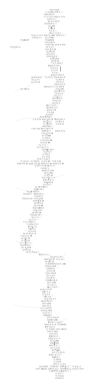

In [ ]:
tf.keras.utils.plot_model(new_model, to_file='m_resunetplusplus_model.png', show_shapes=True, show_layer_names=True)
img = plt.imread('m_resunetplusplus_model.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
import keras

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# from tensorflow.keras.losses import BinaryCrossentropy
# from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.metrics import Precision, Recall, MeanIoU , Accuracy


In [ ]:
smooth = 1.
def dice_score(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
def dice_loss(y_true, y_pred):
    return 1.0 - dice_score(y_true, y_pred)

In [ ]:
def sensitivity(y_true, y_pred):
    # Convert predicted probabilities to binary values (0 or 1)
    y_pred_binary = tf.cast(y_pred > 0.5, dtype=tf.float32)
    # Calculate true positives (TP) and actual positives (AP)
    TP = tf.reduce_sum(y_true * y_pred_binary)
    AP = tf.reduce_sum(y_true)
    # Calculate sensitivity (recall) as TP / AP
    sensitivity = TP / (AP + tf.keras.backend.epsilon())  # Add epsilon to avoid division by zero
    return sensitivity
def specificity(y_true, y_pred):
    # Convert predicted probabilities to binary values (0 or 1)
    y_pred_binary = tf.cast(y_pred > 0.5, dtype=tf.float32)

    # Calculate true negatives (TN)
    TN = tf.reduce_sum((1 - y_true) * (1 - y_pred_binary))

    # Calculate false positives (FP)
    FP = tf.reduce_sum((1 - y_true) * y_pred_binary)

    # Calculate specificity as TN / (TN + FP)
    spec = TN / (TN + FP + tf.keras.backend.epsilon())  # Add epsilon to avoid division by zero

    return spec

In [ ]:
#n_classes = 4
#activation = 'softmax'
LR = 0.0001
#optim = keras.optimizers.Adam(LR)
loss=dice_loss
#loss='binary_crossentropy'
#loss = sm.losses.DiceLoss(class_weights=np.array())
#dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25]))
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)

metrics = [dice_score,MeanIoU(num_classes=2),sm.metrics.IOUScore(threshold=0.5),sm.metrics.FScore(threshold=0.5),Recall(),Precision(),sensitivity,specificity,Accuracy()]
#metrics = [dice_score,MeanIoU(num_classes=2),sm.metrics.IOUScore(threshold=0.5),sm.metrics.FScore(threshold=0.5)]
#metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [ ]:
from tensorflow.keras.optimizers import Nadam
lr=1e-4
optim=Nadam(lr)

In [ ]:
new_model.compile(optim, loss, metrics=metrics)

In [ ]:
new_model.fit(X_train, Y_train, batch_size=16, epochs=1, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy4_1.hdf5')

173/173 [==============================] - 444s 2s/step - loss: 0.6058 - dice_score: 0.3943 - mean_io_u: 0.6904 - iou_score: 0.3208 - f1-score: 0.4650 - recall: 0.9354 - precision: 0.2392 - sensitivity: 0.9366 - specificity: 0.9263 - accuracy: 0.0181


/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# for loading 1 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy4_1.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [ ]:
#training epoch 2 to 10
history_from_1= new_model.fit(X_train, Y_train, batch_size=16, epochs=9, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy4_10.hdf5')

Epoch 1/9
173/173 [==============================] - 441s 2s/step - loss: 0.2672 - dice_score: 0.7329 - mean_io_u: 0.8367 - iou_score: 0.6641 - f1-score: 0.7933 - recall: 0.9111 - precision: 0.7075 - sensitivity: 0.9146 - specificity: 0.9907 - accuracy: 0.0208
Epoch 2/9
173/173 [==============================] - 369s 2s/step - loss: 0.1504 - dice_score: 0.8496 - mean_io_u: 0.8857 - iou_score: 0.7764 - f1-score: 0.8728 - recall: 0.8996 - precision: 0.8561 - sensitivity: 0.9032 - specificity: 0.9963 - accuracy: 0.0208
Epoch 3/9
173/173 [==============================] - 366s 2s/step - loss: 0.1199 - dice_score: 0.8801 - mean_io_u: 0.8982 - iou_score: 0.8047 - f1-score: 0.8911 - recall: 0.8999 - precision: 0.8888 - sensitivity: 0.9029 - specificity: 0.9972 - accuracy: 0.0209
Epoch 4/9
173/173 [==============================] - 367s 2s/step - loss: 0.1014 - dice_score: 0.8986 - mean_io_u: 0.9084 - iou_score: 0.8272 - f1-score: 0.9050 - recall: 0.9067 - precision: 0.9083 - sensitivity: 0.90

/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# for loading 10 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy4_10.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [ ]:
#evaluting for 10 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 39s 621ms/step - loss: 0.0866 - dice_score: 0.9133 - mean_io_u: 0.9211 - iou_score: 0.8421 - f1-score: 0.9140 - recall: 0.9387 - precision: 0.8937 - sensitivity: 0.9361 - specificity: 0.9972 - accuracy: 0.0225


In [ ]:
#training epoch 11 to 20
history_from_10= new_model.fit(X_train, Y_train, batch_size=16, epochs=10, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_20.hdf5')

Epoch 1/10
173/173 [==============================] - 366s 2s/step - loss: 0.0641 - dice_score: 0.9359 - mean_io_u: 0.9330 - iou_score: 0.8823 - f1-score: 0.9373
Epoch 2/10
173/173 [==============================] - 331s 2s/step - loss: 0.0620 - dice_score: 0.9380 - mean_io_u: 0.9351 - iou_score: 0.8849 - f1-score: 0.9388
Epoch 3/10
173/173 [==============================] - 343s 2s/step - loss: 0.0597 - dice_score: 0.9403 - mean_io_u: 0.9370 - iou_score: 0.8884 - f1-score: 0.9408
Epoch 4/10
173/173 [==============================] - 325s 2s/step - loss: 0.0577 - dice_score: 0.9423 - mean_io_u: 0.9391 - iou_score: 0.8917 - f1-score: 0.9426
Epoch 5/10
173/173 [==============================] - 323s 2s/step - loss: 0.0563 - dice_score: 0.9437 - mean_io_u: 0.9401 - iou_score: 0.8941 - f1-score: 0.9440
Epoch 6/10
173/173 [==============================] - 319s 2s/step - loss: 0.0542 - dice_score: 0.9458 - mean_io_u: 0.9420 - iou_score: 0.8978 - f1-score: 0.9460
Epoch 7/10
173/173 [========

/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# for loading 20 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_20.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [ ]:
#evaluting for 20 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 34s 533ms/step - loss: 0.0680 - dice_score: 0.9319 - mean_io_u: 0.9397 - iou_score: 0.8730 - f1-score: 0.9320 - recall: 0.9579 - precision: 0.9105 - sensitivity: 0.9563 - specificity: 0.9976 - accuracy: 0.0241


In [ ]:
#training epoch 21 to 30
history_from_20= new_model.fit(X_train, Y_train, batch_size=16, epochs=10, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy4_30.hdf5')

Epoch 1/10
173/173 [==============================] - 340s 2s/step - loss: 0.0489 - dice_score: 0.9511 - mean_io_u: 0.9473 - iou_score: 0.9072 - f1-score: 0.9513 - recall: 0.9505 - precision: 0.9536 - sensitivity: 0.9501 - specificity: 0.9989 - accuracy: 0.0237
Epoch 2/10
173/173 [==============================] - 318s 2s/step - loss: 0.0485 - dice_score: 0.9515 - mean_io_u: 0.9476 - iou_score: 0.9080 - f1-score: 0.9517 - recall: 0.9507 - precision: 0.9544 - sensitivity: 0.9505 - specificity: 0.9989 - accuracy: 0.0238
Epoch 3/10
173/173 [==============================] - 320s 2s/step - loss: 0.0473 - dice_score: 0.9527 - mean_io_u: 0.9492 - iou_score: 0.9101 - f1-score: 0.9528 - recall: 0.9518 - precision: 0.9554 - sensitivity: 0.9514 - specificity: 0.9989 - accuracy: 0.0242
Epoch 4/10
173/173 [==============================] - 316s 2s/step - loss: 0.0470 - dice_score: 0.9530 - mean_io_u: 0.9497 - iou_score: 0.9106 - f1-score: 0.9531 - recall: 0.9522 - precision: 0.9555 - sensitivity: 

/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# for loading 30 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy4_30.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [ ]:
#evaluting for 30 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 33s 534ms/step - loss: 0.0638 - dice_score: 0.9362 - mean_io_u: 0.9477 - iou_score: 0.8805 - f1-score: 0.9362 - recall: 0.9442 - precision: 0.9614 - sensitivity: 0.9067 - specificity: 0.9993 - accuracy: 0.0256


In [ ]:
#training epoch 31 to 35
history_from_30= new_model.fit(X_train, Y_train, batch_size=16, epochs=5, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy4_35.hdf5')

Epoch 1/5
173/173 [==============================] - 347s 2s/step - loss: 0.0425 - dice_score: 0.9575 - mean_io_u: 0.9542 - iou_score: 0.9187 - f1-score: 0.9576 - recall: 0.9560 - precision: 0.9603 - sensitivity: 0.9558 - specificity: 0.9990 - accuracy: 0.0261
Epoch 2/5
173/173 [==============================] - 319s 2s/step - loss: 0.0427 - dice_score: 0.9573 - mean_io_u: 0.9547 - iou_score: 0.9184 - f1-score: 0.9574 - recall: 0.9569 - precision: 0.9591 - sensitivity: 0.9567 - specificity: 0.9990 - accuracy: 0.0265
Epoch 3/5
173/173 [==============================] - 318s 2s/step - loss: 0.0417 - dice_score: 0.9583 - mean_io_u: 0.9553 - iou_score: 0.9202 - f1-score: 0.9584 - recall: 0.9569 - precision: 0.9611 - sensitivity: 0.9565 - specificity: 0.9990 - accuracy: 0.0265
Epoch 4/5
173/173 [==============================] - 317s 2s/step - loss: 0.0422 - dice_score: 0.9578 - mean_io_u: 0.9552 - iou_score: 0.9194 - f1-score: 0.9579 - recall: 0.9567 - precision: 0.9603 - sensitivity: 0.95

/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# for loading 35 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy4_35.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [ ]:
#evaluting for 35 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 35s 548ms/step - loss: 0.0596 - dice_score: 0.9403 - mean_io_u: 0.9532 - iou_score: 0.8877 - f1-score: 0.9404 - recall: 0.9566 - precision: 0.9536 - sensitivity: 0.9505 - specificity: 0.9982 - accuracy: 0.0267


In [ ]:
#training epoch 36 to 38
history_from_35= new_model.fit(X_train, Y_train, batch_size=16, epochs=3, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy4_38.hdf5')

Epoch 1/3
173/173 [==============================] - 339s 2s/step - loss: 0.0406 - dice_score: 0.9594 - mean_io_u: 0.9566 - iou_score: 0.9222 - f1-score: 0.9595 - recall: 0.9585 - precision: 0.9616 - sensitivity: 0.9582 - specificity: 0.9990 - accuracy: 0.0273
Epoch 2/3
173/173 [==============================] - 317s 2s/step - loss: 0.0403 - dice_score: 0.9598 - mean_io_u: 0.9572 - iou_score: 0.9229 - f1-score: 0.9598 - recall: 0.9589 - precision: 0.9620 - sensitivity: 0.9587 - specificity: 0.9991 - accuracy: 0.0276
Epoch 3/3
173/173 [==============================] - 318s 2s/step - loss: 0.0400 - dice_score: 0.9600 - mean_io_u: 0.9576 - iou_score: 0.9233 - f1-score: 0.9600 - recall: 0.9591 - precision: 0.9621 - sensitivity: 0.9588 - specificity: 0.9991 - accuracy: 0.0273


/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# for loading 38 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy4_38.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [ ]:
#evaluting for 38 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 33s 536ms/step - loss: 0.0613 - dice_score: 0.9387 - mean_io_u: 0.9517 - iou_score: 0.8850 - f1-score: 0.9388 - recall: 0.9484 - precision: 0.9631 - sensitivity: 0.9137 - specificity: 0.9992 - accuracy: 0.0269


In [ ]:
#training epoch 39 to 40
history_from_38= new_model.fit(X_train, Y_train, batch_size=16, epochs=2, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy4_40.hdf5')

Epoch 1/2
173/173 [==============================] - 355s 2s/step - loss: 0.0392 - dice_score: 0.9608 - mean_io_u: 0.9581 - iou_score: 0.9248 - f1-score: 0.9608 - recall: 0.9601 - precision: 0.9626 - sensitivity: 0.9599 - specificity: 0.9991 - accuracy: 0.0276
Epoch 2/2
173/173 [==============================] - 330s 2s/step - loss: 0.0390 - dice_score: 0.9610 - mean_io_u: 0.9582 - iou_score: 0.9252 - f1-score: 0.9611 - recall: 0.9603 - precision: 0.9630 - sensitivity: 0.9600 - specificity: 0.9991 - accuracy: 0.0279


/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# for loading 40 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy4_40.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [ ]:
#evaluting for 40 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 33s 532ms/step - loss: 0.0560 - dice_score: 0.9440 - mean_io_u: 0.9536 - iou_score: 0.8942 - f1-score: 0.9440 - recall: 0.9525 - precision: 0.9628 - sensitivity: 0.9267 - specificity: 0.9991 - accuracy: 0.0274


In [ ]:
#training epoch 41 to 42
history_from_40= new_model.fit(X_train, Y_train, batch_size=16, epochs=2, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy4_42.hdf5')

Epoch 1/2
173/173 [==============================] - 356s 2s/step - loss: 0.0385 - dice_score: 0.9615 - mean_io_u: 0.9587 - iou_score: 0.9260 - f1-score: 0.9615 - recall: 0.9611 - precision: 0.9629 - sensitivity: 0.9607 - specificity: 0.9991 - accuracy: 0.0278
Epoch 2/2
173/173 [==============================] - 334s 2s/step - loss: 0.0385 - dice_score: 0.9615 - mean_io_u: 0.9584 - iou_score: 0.9260 - f1-score: 0.9615 - recall: 0.9607 - precision: 0.9633 - sensitivity: 0.9605 - specificity: 0.9991 - accuracy: 0.0280


/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# for loading 42 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy4_42.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [ ]:
#evaluting for 42 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 33s 531ms/step - loss: 0.0561 - dice_score: 0.9439 - mean_io_u: 0.9416 - iou_score: 0.8941 - f1-score: 0.9439 - recall: 0.9348 - precision: 0.9562 - sensitivity: 0.9323 - specificity: 0.9989 - accuracy: 0.0274


In [ ]:
#training epoch 43 to 44
history_from_42= new_model.fit(X_train, Y_train, batch_size=16, epochs=2, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy4_44.hdf5')

Epoch 1/2
173/173 [==============================] - 349s 2s/step - loss: 0.0379 - dice_score: 0.9621 - mean_io_u: 0.9592 - iou_score: 0.9273 - f1-score: 0.9622 - recall: 0.9613 - precision: 0.9641 - sensitivity: 0.9609 - specificity: 0.9991 - accuracy: 0.0280
Epoch 2/2
173/173 [==============================] - 331s 2s/step - loss: 0.0379 - dice_score: 0.9621 - mean_io_u: 0.9593 - iou_score: 0.9271 - f1-score: 0.9621 - recall: 0.9611 - precision: 0.9642 - sensitivity: 0.9609 - specificity: 0.9991 - accuracy: 0.0285


/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# for loading 44 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy4_44.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [ ]:
#evaluting for 44 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 36s 531ms/step - loss: 0.0586 - dice_score: 0.9414 - mean_io_u: 0.9536 - iou_score: 0.8896 - f1-score: 0.9414 - recall: 0.9503 - precision: 0.9655 - sensitivity: 0.9154 - specificity: 0.9993 - accuracy: 0.0282


In [ ]:
#training epoch 45 to 46
history_from_44= new_model.fit(X_train, Y_train, batch_size=16, epochs=2, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy4_46.hdf5')

Epoch 1/2
173/173 [==============================] - 354s 2s/step - loss: 0.0373 - dice_score: 0.9627 - mean_io_u: 0.9600 - iou_score: 0.9283 - f1-score: 0.9628 - recall: 0.9619 - precision: 0.9644 - sensitivity: 0.9618 - specificity: 0.9991 - accuracy: 0.0296
Epoch 2/2
173/173 [==============================] - 336s 2s/step - loss: 0.0372 - dice_score: 0.9628 - mean_io_u: 0.9602 - iou_score: 0.9285 - f1-score: 0.9629 - recall: 0.9620 - precision: 0.9647 - sensitivity: 0.9616 - specificity: 0.9991 - accuracy: 0.0294


/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# for loading 46 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy4_46.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [ ]:
#evaluting for 46 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 35s 529ms/step - loss: 0.0547 - dice_score: 0.9453 - mean_io_u: 0.9558 - iou_score: 0.8965 - f1-score: 0.9453 - recall: 0.9547 - precision: 0.9637 - sensitivity: 0.9311 - specificity: 0.9990 - accuracy: 0.0292


In [ ]:
#training epoch 47 to 48
history_from_46= new_model.fit(X_train, Y_train, batch_size=16, epochs=2, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy4_48.hdf5')

Epoch 1/2
173/173 [==============================] - 353s 2s/step - loss: 0.0369 - dice_score: 0.9631 - mean_io_u: 0.9608 - iou_score: 0.9290 - f1-score: 0.9631 - recall: 0.9628 - precision: 0.9643 - sensitivity: 0.9624 - specificity: 0.9991 - accuracy: 0.0294
Epoch 2/2
173/173 [==============================] - 320s 2s/step - loss: 0.0369 - dice_score: 0.9631 - mean_io_u: 0.9606 - iou_score: 0.9290 - f1-score: 0.9632 - recall: 0.9625 - precision: 0.9646 - sensitivity: 0.9623 - specificity: 0.9991 - accuracy: 0.0299


/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# for loading 48 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy4_48.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [ ]:
#evaluting for 48 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 35s 540ms/step - loss: 0.0638 - dice_score: 0.9362 - mean_io_u: 0.9527 - iou_score: 0.8806 - f1-score: 0.9363 - recall: 0.9474 - precision: 0.9674 - sensitivity: 0.9002 - specificity: 0.9994 - accuracy: 0.0293


In [ ]:
#training epoch 49 to 51
history_from_48= new_model.fit(X_train, Y_train, batch_size=16, epochs=3, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy4_51.hdf5')

Epoch 1/3
173/173 [==============================] - 356s 2s/step - loss: 0.0367 - dice_score: 0.9633 - mean_io_u: 0.9606 - iou_score: 0.9295 - f1-score: 0.9634 - recall: 0.9622 - precision: 0.9654 - sensitivity: 0.9619 - specificity: 0.9991 - accuracy: 0.0295
Epoch 2/3
173/173 [==============================] - 337s 2s/step - loss: 0.0362 - dice_score: 0.9638 - mean_io_u: 0.9612 - iou_score: 0.9303 - f1-score: 0.9638 - recall: 0.9637 - precision: 0.9650 - sensitivity: 0.9634 - specificity: 0.9991 - accuracy: 0.0294
Epoch 3/3
173/173 [==============================] - 335s 2s/step - loss: 0.0357 - dice_score: 0.9643 - mean_io_u: 0.9614 - iou_score: 0.9312 - f1-score: 0.9643 - recall: 0.9633 - precision: 0.9662 - sensitivity: 0.9631 - specificity: 0.9992 - accuracy: 0.0298


/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# for loading 51 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy4_51.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [ ]:
#evaluting for 51 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 33s 531ms/step - loss: 0.0531 - dice_score: 0.9469 - mean_io_u: 0.9569 - iou_score: 0.8995 - f1-score: 0.9470 - recall: 0.9561 - precision: 0.9653 - sensitivity: 0.9325 - specificity: 0.9991 - accuracy: 0.0294


In [ ]:
#training epoch 52
history_from_51= new_model.fit(X_train, Y_train, batch_size=16, epochs=1, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy4_52.hdf5')

173/173 [==============================] - 357s 2s/step - loss: 0.0348 - dice_score: 0.9652 - mean_io_u: 0.9623 - iou_score: 0.9328 - f1-score: 0.9652 - recall: 0.9644 - precision: 0.9667 - sensitivity: 0.9642 - specificity: 0.9992 - accuracy: 0.0301


/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# for loading 52 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy4_52.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [ ]:
#evaluting for 52 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 36s 533ms/step - loss: 0.0545 - dice_score: 0.9455 - mean_io_u: 0.9571 - iou_score: 0.8970 - f1-score: 0.9456 - recall: 0.9558 - precision: 0.9662 - sensitivity: 0.9281 - specificity: 0.9991 - accuracy: 0.0296


In [ ]:
#training epoch 53 to 54
history_from_52= new_model.fit(X_train, Y_train, batch_size=16, epochs=2, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy4_54.hdf5')

Epoch 1/2
173/173 [==============================] - 361s 2s/step - loss: 0.0347 - dice_score: 0.9653 - mean_io_u: 0.9624 - iou_score: 0.9331 - f1-score: 0.9653 - recall: 0.9647 - precision: 0.9667 - sensitivity: 0.9645 - specificity: 0.9992 - accuracy: 0.0300
Epoch 2/2
173/173 [==============================] - 339s 2s/step - loss: 0.0354 - dice_score: 0.9646 - mean_io_u: 0.9623 - iou_score: 0.9319 - f1-score: 0.9647 - recall: 0.9639 - precision: 0.9664 - sensitivity: 0.9637 - specificity: 0.9992 - accuracy: 0.0306


/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# for loading 54 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy4_54.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [ ]:
#evaluting for 54 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 37s 535ms/step - loss: 0.0564 - dice_score: 0.9435 - mean_io_u: 0.9564 - iou_score: 0.8935 - f1-score: 0.9436 - recall: 0.9532 - precision: 0.9673 - sensitivity: 0.9189 - specificity: 0.9993 - accuracy: 0.0301


In [ ]:
#training epoch 55 to 56
history_from_54= new_model.fit(X_train, Y_train, batch_size=16, epochs=2, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy4_56.hdf5')

Epoch 1/2
173/173 [==============================] - 361s 2s/step - loss: 0.0346 - dice_score: 0.9654 - mean_io_u: 0.9628 - iou_score: 0.9333 - f1-score: 0.9654 - recall: 0.9651 - precision: 0.9665 - sensitivity: 0.9649 - specificity: 0.9992 - accuracy: 0.0310
Epoch 2/2
173/173 [==============================] - 336s 2s/step - loss: 0.0345 - dice_score: 0.9655 - mean_io_u: 0.9630 - iou_score: 0.9335 - f1-score: 0.9655 - recall: 0.9652 - precision: 0.9668 - sensitivity: 0.9649 - specificity: 0.9992 - accuracy: 0.0313


/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# for loading 56 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy4_56.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [ ]:
#evaluting for 56 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 37s 534ms/step - loss: 0.0539 - dice_score: 0.9460 - mean_io_u: 0.9579 - iou_score: 0.8979 - f1-score: 0.9461 - recall: 0.9563 - precision: 0.9666 - sensitivity: 0.9277 - specificity: 0.9992 - accuracy: 0.0308


In [ ]:
#training epoch 57
history_from_56= new_model.fit(X_train, Y_train, batch_size=16, epochs=1, shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy4_57.hdf5')

173/173 [==============================] - 355s 2s/step - loss: 0.0344 - dice_score: 0.9656 - mean_io_u: 0.9633 - iou_score: 0.9337 - f1-score: 0.9656 - recall: 0.9649 - precision: 0.9672 - sensitivity: 0.9646 - specificity: 0.9992 - accuracy: 0.0315


/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# for loading 57 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy4_57.hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [ ]:
#evaluting for 57 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 34s 555ms/step - loss: 0.0605 - dice_score: 0.9395 - mean_io_u: 0.9561 - iou_score: 0.8863 - f1-score: 0.9395 - recall: 0.9513 - precision: 0.9687 - sensitivity: 0.9083 - specificity: 0.9994 - accuracy: 0.0313


In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=2)

In [ ]:
#training epoch 58 to 60
history_from_57= new_model.fit(X_train, Y_train, batch_size=16, epochs=3, callbacks=[early_stopping], shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy4_best(58,60).hdf5')

Epoch 1/3
173/173 [==============================] - 354s 2s/step - loss: 0.0341 - dice_score: 0.9659 - mean_io_u: 0.9635 - iou_score: 0.9342 - f1-score: 0.9660 - recall: 0.9658 - precision: 0.9669 - sensitivity: 0.9656 - specificity: 0.9992 - accuracy: 0.0310
Epoch 2/3
173/173 [==============================] - 324s 2s/step - loss: 0.0344 - dice_score: 0.9656 - mean_io_u: 0.9630 - iou_score: 0.9337 - f1-score: 0.9657 - recall: 0.9652 - precision: 0.9669 - sensitivity: 0.9651 - specificity: 0.9992 - accuracy: 0.0311
Epoch 3/3
173/173 [==============================] - 325s 2s/step - loss: 0.0335 - dice_score: 0.9665 - mean_io_u: 0.9641 - iou_score: 0.9353 - f1-score: 0.9665 - recall: 0.9662 - precision: 0.9676 - sensitivity: 0.9659 - specificity: 0.9992 - accuracy: 0.0320


/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
#evaluting for 60 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 33s 534ms/step - loss: 0.0508 - dice_score: 0.9492 - mean_io_u: 0.9507 - iou_score: 0.9035 - f1-score: 0.9492 - recall: 0.9509 - precision: 0.9501 - sensitivity: 0.9494 - specificity: 0.9987 - accuracy: 0.0316


In [ ]:
#training epoch 61 to 65
history_from_60= new_model.fit(X_train, Y_train, batch_size=16, epochs=5, callbacks=[early_stopping], shuffle=False)

new_model.save('./Brats2020_2DSegmentation_nadam_customUnet_copy4_best(61,65).hdf5')

Epoch 1/5
173/173 [==============================] - 360s 2s/step - loss: 0.0331 - dice_score: 0.9669 - mean_io_u: 0.9641 - iou_score: 0.9360 - f1-score: 0.9669 - recall: 0.9659 - precision: 0.9687 - sensitivity: 0.9657 - specificity: 0.9992 - accuracy: 0.0317
Epoch 2/5
173/173 [==============================] - 342s 2s/step - loss: 0.0330 - dice_score: 0.9670 - mean_io_u: 0.9646 - iou_score: 0.9362 - f1-score: 0.9670 - recall: 0.9667 - precision: 0.9682 - sensitivity: 0.9664 - specificity: 0.9992 - accuracy: 0.0329
Epoch 3/5
173/173 [==============================] - 343s 2s/step - loss: 0.0327 - dice_score: 0.9673 - mean_io_u: 0.9649 - iou_score: 0.9367 - f1-score: 0.9673 - recall: 0.9669 - precision: 0.9684 - sensitivity: 0.9666 - specificity: 0.9992 - accuracy: 0.0321
Epoch 4/5
173/173 [==============================] - 340s 2s/step - loss: 0.0326 - dice_score: 0.9674 - mean_io_u: 0.9649 - iou_score: 0.9370 - f1-score: 0.9675 - recall: 0.9673 - precision: 0.9685 - sensitivity: 0.96

/home/arka/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# for loading 65 epoch trained model
from keras.models import load_model

new_model = load_model(r'./Brats2020_2DSegmentation_nadam_customUnet_copy4_best(61,65).hdf5', compile=False)

new_model.compile(optim, loss, metrics=metrics)

In [ ]:
#evaluting for 65 epochs
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 [==============================] - 34s 539ms/step - loss: 0.0539 - dice_score: 0.9461 - mean_io_u: 0.9614 - iou_score: 0.8980 - f1-score: 0.9461 - recall: 0.9643 - precision: 0.9620 - sensitivity: 0.9546 - specificity: 0.9984 - accuracy: 0.0331


In [ ]:
keras.backend.clear_session()

In [ ]:
from tensorflow.keras.models import load_model
import os



# Step 2: Specify the path to the HDF5 file in your Google Drive
hdf5_file_path = "/content/drive/MyDrive/final yr project/Brats2020_2DSegmentation_nadam_customUnet_copy4_best(58,60).hdf5"
print(os.path.exists(hdf5_file_path))

True


In [ ]:
new_model = load_model(hdf5_file_path,compile=False)


In [ ]:
new_model.compile(optim, loss, metrics=metrics)

In [ ]:
res = new_model.evaluate(X_test,Y_test,batch_size=16)

58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.0308 - dice_score: 0.9490 - f1-score: 0.9491 - iou_score: 0.9032 - loss: 0.0510 - mean_io_u_1: 0.9503 - precision_1: 0.9500 - recall_1: 0.9504 - sensitivity: 0.9493 - specificity: 0.9988


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


Text(0.5, 1.0, 'prediction 839')

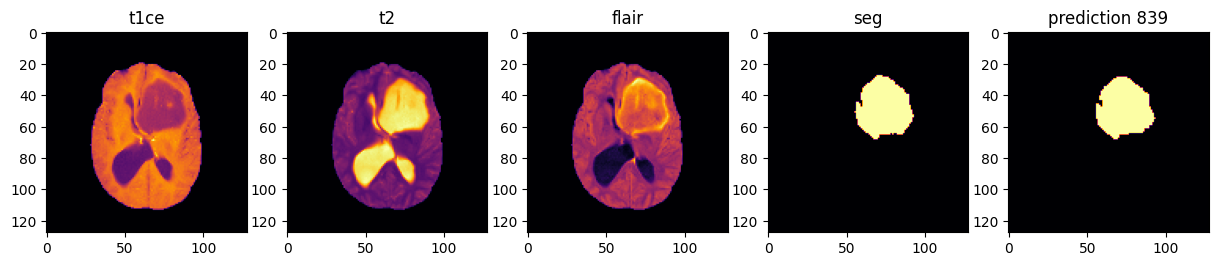

In [ ]:
# PREDICTING FOR 60 EPOCH
img_num = random.randint(0,len(X_test)-1)
random_img_t1ce = X_test[img_num,:,:,0]
random_img_t2 = X_test[img_num,:,:,1]
random_img_flair = X_test[img_num,:,:,2]
random_img_seg = Y_test[img_num,:,:,0]

img=np.expand_dims(X_test[img_num], axis=0)
preds_val = new_model.predict(img, verbose=1)


preds_val=preds_val[0]
preds_val = (preds_val > 0.5)
fig = plt.figure(figsize =(15, 15))

ax1 = fig.add_subplot(1, 5, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(1, 5, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(1, 5, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(1, 5, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

ax1 = fig.add_subplot(1, 5, 5)
ax1.imshow(preds_val, cmap='inferno')
plt.title(f"prediction {img_num}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Text(0.5, 1.0, 'prediction 324')

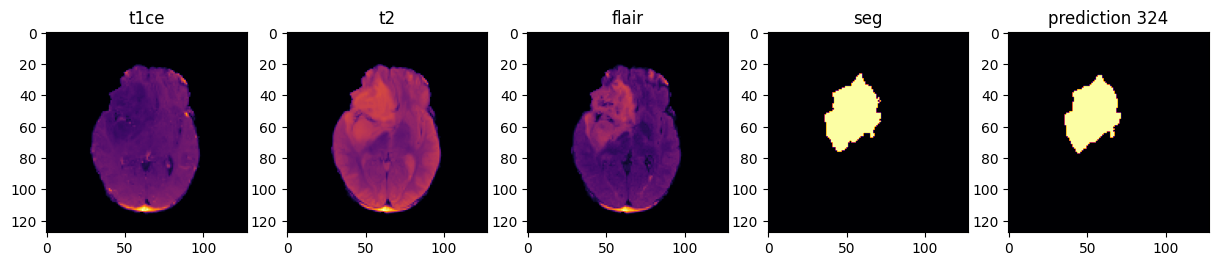

In [ ]:
# PREDICTING FOR 60 EPOCH (NOT RANDOM)
img_num =324
random_img_t1ce = X_test[img_num,:,:,0]
random_img_t2 = X_test[img_num,:,:,1]
random_img_flair = X_test[img_num,:,:,2]
random_img_seg = Y_test[img_num,:,:,0]

img=np.expand_dims(X_test[img_num], axis=0)
preds_val = new_model.predict(img, verbose=1)


preds_val=preds_val[0]
preds_val = (preds_val > 0.5)
fig = plt.figure(figsize =(15, 15))

ax1 = fig.add_subplot(1, 5, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(1, 5, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(1, 5, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(1, 5, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

ax1 = fig.add_subplot(1, 5, 5)
ax1.imshow(preds_val, cmap='inferno')
plt.title(f"prediction {img_num}")

1/1 [==============================] - 0s 48ms/step


Text(0.5, 1.0, 'prediction 76')

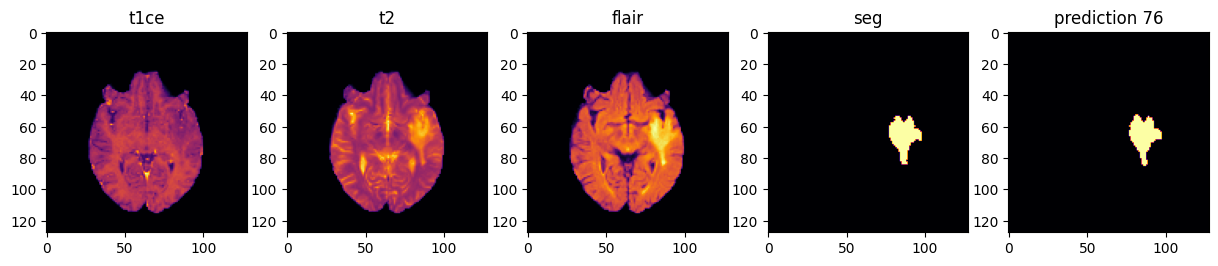

In [ ]:
# PREDICTING FOR 60 EPOCH
img_num = random.randint(0,len(X_test)-1)
random_img_t1ce = X_test[img_num,:,:,0]
random_img_t2 = X_test[img_num,:,:,1]
random_img_flair = X_test[img_num,:,:,2]
random_img_seg = Y_test[img_num,:,:,0]

img=np.expand_dims(X_test[img_num], axis=0)
preds_val = new_model.predict(img, verbose=1)


preds_val=preds_val[0]
preds_val = (preds_val > 0.5)
fig = plt.figure(figsize =(15, 15))

ax1 = fig.add_subplot(1, 5, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(1, 5, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(1, 5, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(1, 5, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

ax1 = fig.add_subplot(1, 5, 5)
ax1.imshow(preds_val, cmap='inferno')
plt.title(f"prediction {img_num}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Text(0.5, 1.0, 'prediction 683')

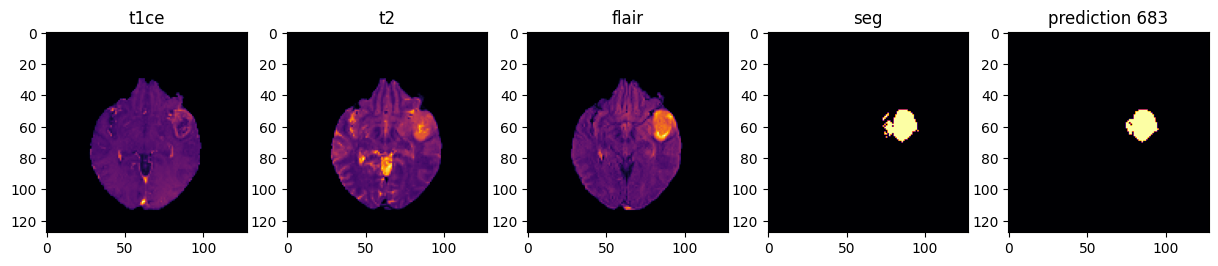

In [ ]:
# PREDICTING FOR 60 EPOCH
img_num = random.randint(0,len(X_test)-1)
random_img_t1ce = X_test[img_num,:,:,0]
random_img_t2 = X_test[img_num,:,:,1]
random_img_flair = X_test[img_num,:,:,2]
random_img_seg = Y_test[img_num,:,:,0]

img=np.expand_dims(X_test[img_num], axis=0)
preds_val = new_model.predict(img, verbose=1)


preds_val=preds_val[0]
preds_val = (preds_val > 0.5)
fig = plt.figure(figsize =(15, 15))

ax1 = fig.add_subplot(1, 5, 1)
ax1.imshow(random_img_t1ce, cmap='inferno')
plt.title("t1ce")

ax1 = fig.add_subplot(1, 5, 2)
ax1.imshow(random_img_t2, cmap='inferno')
plt.title("t2")

ax1 = fig.add_subplot(1, 5, 3)
ax1.imshow(random_img_flair, cmap='inferno')
plt.title("flair")

ax1 = fig.add_subplot(1, 5, 4)
ax1.imshow(random_img_seg, cmap='inferno')
plt.title("seg")

ax1 = fig.add_subplot(1, 5, 5)
ax1.imshow(preds_val, cmap='inferno')
plt.title(f"prediction {img_num}")

In [ ]:
#324
#773
#139
#135
#839
#76